In [15]:
# exit the virtualenv with "deactivate"
import pandas as pd
import sqlalchemy as sqla
fullfile = "../data/test.tsv"
"""
So far: 
- make sure split has length of exactly 7
- the one line before the ones with len(id) != 16 is removed too? depends on contents of the extra lines
- either remove long titles, or extract it somehow?
- do further analysis to optimize/trim down results (40k is more than enough already)
- trim text before "Advanced Job Search" and after "Just posted", "original job", or "Report job"
    - maybe look for "Report job" and count the number of backticks before it to trim everything
""";

In [10]:
# Number of jobs (?)
i = 0
with open(fullfile, encoding="utf-8") as file1:
    for line in file1:
        i = i + 1
print(i)

45444


In [11]:
# Number of messed-up entries (w/o job keys)
j = 0
with open(fullfile, encoding="utf-8") as file1:
    for line in file1:
#         print(line[:20])
        if(len(line)>18 and 
           str(line)[16]!="\t"):
            j = j + 1
#             print(line[:30], end=" | ")
print("\nNumber of rows without job keys: "+str(j))


Number of rows without job keys: 3612


In [12]:
# find distribution of lengths? or highest length?
lenTtl = []   # Title
lenRcn = []   # Recency
lenTS = []    # Timestamp (can find this ourselves)
lenInfo = []  # Company Info.
lenQry = []   # Query (can find this ourselves)
lenDsc = []   # Full Job Desc.
with open(fullfile, encoding="utf-8") as file1:
#     print(file1.readline())
    for line in file1.readlines():
        splitted = line.split("\t")
        if(len(splitted)==7):
            lenTtl.append(len(splitted[1]))
#             if(len(splitted[1])>100):
#                 print(splitted[1])    # Sometimes includes company name, job details...
            lenRcn.append(len(splitted[2]))
            lenTS.append(len(splitted[3]))
            lenInfo.append(len(splitted[4]))
            lenQry.append(len(splitted[5]))
#             lenDsc.append(len(splitted[6]))  # temp. disabled to search cleaned data first
            tempT = splitted[6]
            tempI1 = tempT.find("Job Description")
            tempI2 = tempT.find("Report job")
            cleanedDesc = tempT[tempI1+15:tempI2]
            if(tempI1!=-1 and tempI2 !=-1):
                lenDsc.append(len(cleanedDesc))
print("==Maximum Lengths==\nTitles: {}\nRecency: {}\nTimestamps: {}\nCompany info: {}\nQuery: {}\nTexts: {}\n".format(max(lenTtl),max(lenRcn),max(lenTS),max(lenInfo),max(lenQry),max(lenDsc)))

==Maximum Lengths==
Titles: 162
Recency: 11
Timestamps: 24
Company info: 126
Query: 23
Texts: 26565



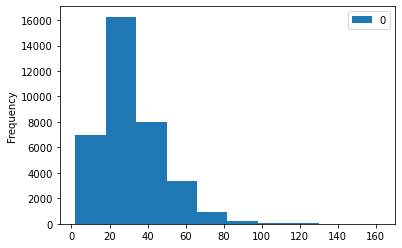

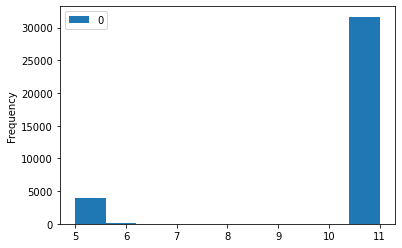

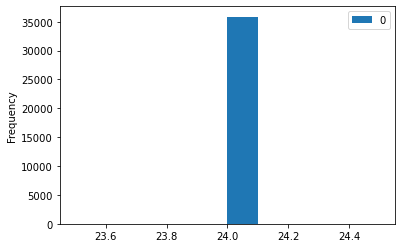

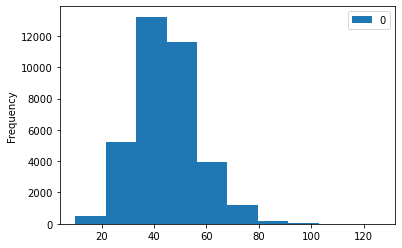

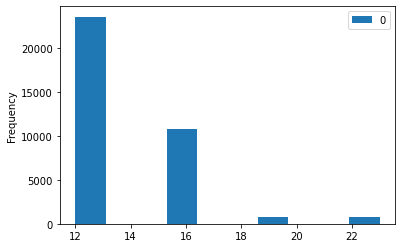

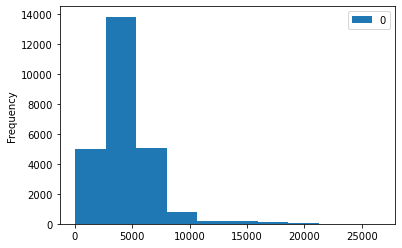

In [14]:
# plot dist's of the lengths
## to find out how to get the most of the good data (and leave bad data behind)
## turns out, there is no need for this in SQLite, which helps us ignore arbitrary limits: https://www.sqlite.org/limits.html
allLens = [lenTtl,lenRcn,lenTS,lenInfo,lenQry,lenDsc]
for len_ in allLens: 
    pd.DataFrame(len_).plot.hist()

In [13]:
# see how many have "full job description" or "job description" (and what index they're at?)
FJDs = 0
JDs = 0
neither = 0
count = 0    # for limiting output
with open(fullfile, encoding="utf-8") as file1:
    for line in file1.readlines():
        splitted = line.split("\t")
        if(len(splitted)==7):
            if(splitted[6].find("Full Job Description") != -1):
                FJDs = FJDs + 1
            elif(splitted[6].find("Job Description") != -1):
                JDs = JDs + 1
            else:
                neither = neither + 1
                ## Print out some of these "neither" rows, see what they use instead
                if(count%5000 == 0):  # ~10k total, so for n outputs, we do %(10000/n)
                    print(splitted[6])
                    pass
                count = count + 1
print("Full JD's: {}\nJD's: {}\nNeither: {}".format(FJDs, JDs, neither))

03e5cffe7601c947 at |Amazon Web Services, Inc.|69,393 reviews|Pasadena, CA. Desc.: ````Software Development Engineer Machine Learning Intern (Summer 2021) - Pasadena, CA - Indeed.com```````````````````````````Skip to main content`Indeed Home`Find jobs`Company reviews`Find salaries`Upload your resume`Sign in`Employers / Post Job`Skip to main content`Indeed Home`Sign in`Find jobs`Company reviews`Find salaries`Employers`Create your resume`Change country`🇺🇸 United States`Help Center`````What`Where`Find Jobs`Advanced Job Search`Software Development Engineer Machine Learning Intern (Summer 2021)`Amazon Web Services, Inc.`69,393 reviews`Pasadena, CA`Amazon Web Services, Inc.`69,393 reviews`Read what people are saying about working here.`Job`Company```Programming experience with at least one modern language such as Java, C++, or C# including object-oriented design```Currently enrolled in a Bachelor’s or Master’s degree program in Computer Science, Computer Engineering, or related technical dis

08937847cd24ed16 at |The Westervelt Company|Tuscaloosa, AL 35404. Desc.: ````Business Intelligence Analyst - Tuscaloosa, AL 35404 - Indeed.com`````````````````````````Skip to main content`Indeed Home`Find jobs`Company reviews`Find salaries`Upload your resume`Sign in`Employers / Post Job`Skip to main content`Indeed Home`Sign in`Find jobs`Company reviews`Find salaries`Employers`Create your resume`Change country`🇺🇸 United States`Help Center`Start of main content`````What`Where`Find Jobs`Advanced Job Search`Business Intelligence Analyst`The Westervelt Company`Tuscaloosa, AL 35404`At The Westervelt Company, we are stewards of the land. We believe in sustainable management, conservation and protection of our natural resources. We are committed to our core values of ensuring the safety and well-being of our employees, providing the highest quality products and services for our customers, and developing long-lasting relationships in the communities where we live and work.``We are searching for

Full JD's: 24426
JD's: 908
Neither: 10529


In [16]:
#### Clean & Upload to SQLite database
## First, create the file
sqlite_file = '../data/cleaned.sqlite'
cnx = sqla.create_engine('sqlite:///' + sqlite_file)

In [20]:
## Try some queries
# https://www.sqlitetutorial.net/sqlite-tutorial/sqlite-show-tables/
# pd.DataFrame.to_sql(), pd.read_sql_query()
pd.read_sql_query("""SELECT name 
                  FROM sqlite_master 
                  WHERE type=='table' 
                  AND name NOT LIKE 'sqlite_%'""", cnx)

,name


In [30]:
# testing
with open(fullfile, encoding="utf-8") as file1:
    aline = file1.readline()
#     print(type(aline)) #str
    print(aline[:350])
    spl = aline.split('\t')
    tempdf = pd.DataFrame({"Key":[spl[0]], 
                        "Title":[spl[1]], 
                        "Recency":[spl[2]], 
                        "Time_Scraped":[spl[3]], 
                        "Company_Details":[spl[4]], 
                        "Query":[spl[5]], 
                        "Description":[spl[6]]})      # https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
    print(tempdf)

bdbe0aede8bdc282	Research Intern	Just posted	Thu Apr 15 22:59:04 2021	|Lenovo|1,096 reviews|Morrisville, NC	machine learning intern	bdbe0aede8bdc282 at |Lenovo|1,096 reviews|Morrisville, NC. Desc.: ````Research Intern - Morrisville, NC - Indeed.com`````````````````````````````Skip to main content`Indeed Home`Find jobs`Company reviews`Find salaries`
                Key            Title      Recency              Time_Scraped  \
0  bdbe0aede8bdc282  Research Intern  Just posted  Thu Apr 15 22:59:04 2021   

                         Company_Details                    Query  \
0  |Lenovo|1,096 reviews|Morrisville, NC  machine learning intern   

                                         Description  
0  bdbe0aede8bdc282 at |Lenovo|1,096 reviews|Morr...  


In [32]:
## Clean & Upload the data
# # https://stackoverflow.com/questions/17839973/constructing-pandas-dataframe-from-values-in-variables-gives-valueerror-if-usi
counter=0
#### TODO: VECTORIZE! Use chunks, numpy.vectorize(pyfunc), save time wherever possible
    ## Maybe try to add it as an entry instead of creating a new file every time?
with open(fullfile, encoding="utf-8") as file1:
    ## Initialize a table in the database; clear the old one
    aline = file1.readline()
#     print(type(aline)) #str
#     print(aline[:350])
    spl = aline.split('\t')
    tempdf = pd.DataFrame({"Key":[spl[0]], 
                        "Title":[spl[1]], 
                        "Recency":[spl[2]], 
                        "Time_Scraped":[spl[3]], 
                        "Company_Details":[spl[4]], 
                        "Query":[spl[5]], 
                        "Description":[spl[6]]})      # first one will contain full page text, later ones will be cleaned
    tempdf.to_sql('clean_jobs',cnx,if_exists='replace')
    counter += 1
    print(counter)
    
    ## Loop through the others and append them
    for line in file1.readlines():
        splitted = line.split("\t")
        if(len(splitted)==7):
            tempT = splitted[6]  # removing text before "Desc:" is unnecessary because we start after it ("FJD") anyways
            tempI1 = tempT.find("Job Description")
            tempI2 = tempT.find("Report job")
            if(tempI1==-1 or tempI2 ==-1):
                continue  # no FJD or report job
            cleanedDesc = tempT[tempI1+16:tempI2]
            tempdf = pd.DataFrame({"Key":[splitted[0]], 
                        "Title":[splitted[1]], 
                        "Recency":[splitted[2]], 
                        "Time_Scraped":[splitted[3]], 
                        "Company_Details":[splitted[4]], 
                        "Query":[splitted[5]], 
                        "Description":[cleanedDesc]})
            tempdf.to_sql('clean_jobs',cnx,if_exists='append')
            counter += 1
            print(counter)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [33]:
pd.read_sql_query("""SELECT * 
                  FROM clean_jobs
                  LIMIT 5""", cnx)

,index,Key,Title,Recency,Time_Scraped,Company_Details,Query,Description
0,0,bdbe0aede8bdc282,Research Intern,Just posted,Thu Apr 15 22:59:04 2021,"|Lenovo|1,096 reviews|Morrisville, NC",machine learning intern,"bdbe0aede8bdc282 at |Lenovo|1,096 reviews|Morr..."
1,0,12303968d69f27e1,Junior Data Scientist Intern,Just posted,Thu Apr 15 22:59:04 2021,"|Munich Re America|131 reviews|Princeton, NJ 0...",machine learning intern,`The Junior Data Scientist Intern will gain ex...
2,0,9f8bfec8b1277d4c,"Intern, ITS Data Analytics (Denver)",Just posted,Thu Apr 15 22:59:05 2021,"|Avanade|284 reviews|Denver, CO",machine learning intern,"`Do you enjoy solving problems, turning data i..."
3,0,496be02744d8c5ce,Software Engineering Intern Summer 2021,Just posted,Thu Apr 15 22:59:05 2021,"|Quantcast|22 reviews|San Francisco, CA 94103",machine learning intern,`Quantcast is hiring Software Engineering Inte...
4,0,4a60300b0d1444e5,Video Processing Research Intern (Summer 2021),Just posted,Thu Apr 15 22:59:05 2021,"|Dolby|96 reviews|Sunnyvale, CA 94085",machine learning intern,`The world is changing as we know it. It’s mor...
